In [1]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
image_path = "C:/Users/Madhu/Downloads/Images"
captions_english = "C:/Users/Madhu/OneDrive/Desktop/Sem6/nlp/project/captions_english.txt"
captions_hindi = "C:/Users/Madhu/OneDrive/Desktop/Sem6/nlp/project/captions_hindi.txt"
captions_malayalam = "C:/Users/Madhu/OneDrive/Desktop/Sem6/nlp/project/captions_malayalam.txt"
jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16182


In [3]:
from itertools import zip_longest

# Open the text files
with open(captions_english, 'r', encoding='utf-8') as file:
    text_english = file.read().splitlines()

with open(captions_hindi, 'r', encoding='utf-8') as file:
    text_hindi = file.read().splitlines()

with open(captions_malayalam, 'r', encoding='utf-8') as file:
    text_malayalam = file.read().splitlines()

# Process the text
datatxt = []
for line_english, line_hindi, line_malayalam in zip_longest(text_english, text_hindi, text_malayalam, fillvalue=''):
    col_english = line_english.split(',')
    col_hindi = line_hindi.split(',')
    col_malayalam = line_malayalam.split(',')
    if len(col_english) != 2 or len(col_hindi) != 2 or len(col_malayalam) != 2:
        continue
    filename = col_english[0].strip()
    captions_english = col_english[1].strip().lower()
    captions_hindi = col_hindi[1].strip().lower()
    captions_malayalam = col_malayalam[1].strip().lower()

    # Add the data to the list
    datatxt.append([filename, captions_english, captions_hindi, captions_malayalam])

# Create a DataFrame
data = pd.DataFrame(datatxt, columns=["filename", "captions_english", "captions_hindi", "captions_malayalam"])
uni_filenames = data["filename"].unique()

# Display the first few rows of the DataFrame
data.head()


,filename,captions_english,captions_hindi,captions_malayalam
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...,गुलाबी पोशाक में एक बच्चा प्रवेश मार्ग में सीढ...,പിങ്ക് വസ്ത്രം ധരിച്ച ഒരു കുട്ടി പ്രവേശന വഴിയി...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .,एक लड़की लकड़ी की इमारत में जा रही है।,ഒരു തടി കെട്ടിടത്തിലേക്ക് പോകുന്ന ഒരു പെൺകുട്ടി.
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .,एक छोटी लड़की लकड़ी के प्लेहाउस में चढ़ती है।,ഒരു കൊച്ചു പെൺകുട്ടി ഒരു തടി കളിസ്ഥലത്തേക്ക് ക...
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...,एक छोटी सी लड़की अपने प्लेहाउस की सीढ़ियाँ चढ़...,ഒരു കൊച്ചു പെൺകുട്ടി തൻ്റെ കളിസ്ഥലത്തേക്കുള്ള ...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...,गुलाबी पोशाक में एक छोटी लड़की लकड़ी के केबिन ...,പിങ്ക് വസ്ത്രം ധരിച്ച ഒരു കൊച്ചു പെൺകുട്ടി തടി...


vocabulary 

In [4]:
## Vocabulary Size 
vocabulary_english = []
for txt in data.captions_english.values:
   vocabulary_english.extend(txt.split())
print('Vocabulary Size of english: %d' % len(set(vocabulary_english)))

vocabulary_hindi = []
for txt in data.captions_hindi.values:
   vocabulary_hindi.extend(txt.split())
print('Vocabulary Size of hindi: %d' % len(set(vocabulary_hindi)))

vocabulary_malayalam=[]
for txt in data.captions_malayalam.values:
   vocabulary_malayalam.extend(txt.split())
print('Vocabulary Size of malayalam: %d' % len(set(vocabulary_malayalam)))

Vocabulary Size of english: 8514
Vocabulary Size of hindi: 7881
Vocabulary Size of malayalam: 18010


In [5]:

def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.captions_english.values):
   newcaption = text_clean(caption)
   data["captions_english"].iloc[i] = newcaption




#Adding tags <start> <end>

In [6]:
all_captions_english = []
for caption  in data["captions_english"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions_english.append(caption)

all_captions_english[:10]


all_captions_hindi = []
for caption  in data["captions_hindi"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions_hindi.append(caption)

all_captions_hindi[:2]


all_captions_malayalam = []
for caption  in data["captions_malayalam"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions_malayalam.append(caption)

all_captions_malayalam[:2]

['<start> പിങ്ക് വസ്ത്രം ധരിച്ച ഒരു കുട്ടി പ്രവേശന വഴിയിൽ ഒരു കൂട്ടം പടികൾ കയറുന്നു. <end>',
 '<start> ഒരു തടി കെട്ടിടത്തിലേക്ക് പോകുന്ന ഒരു പെൺകുട്ടി. <end>']

In [7]:
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = image_path +"/"+ annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['C:/Users/Madhu/Downloads/Images/1000268201_693b08cb0e.jpg',
 'C:/Users/Madhu/Downloads/Images/1000268201_693b08cb0e.jpg',
 'C:/Users/Madhu/Downloads/Images/1000268201_693b08cb0e.jpg',
 'C:/Users/Madhu/Downloads/Images/1000268201_693b08cb0e.jpg',
 'C:/Users/Madhu/Downloads/Images/1000268201_693b08cb0e.jpg',
 'C:/Users/Madhu/Downloads/Images/1001773457_577c3a7d70.jpg',
 'C:/Users/Madhu/Downloads/Images/1001773457_577c3a7d70.jpg',
 'C:/Users/Madhu/Downloads/Images/1001773457_577c3a7d70.jpg',
 'C:/Users/Madhu/Downloads/Images/1001773457_577c3a7d70.jpg',
 'C:/Users/Madhu/Downloads/Images/1001773457_577c3a7d70.jpg']

In [8]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions_english) : {len(all_captions_english)}")
print(f"len(all_captions_hindi) : {len(all_captions_hindi)}")
print(f"len(all_captions_malayalam) : {len(all_captions_malayalam)}")
all_captions_size = {len(all_captions_english)+len(all_captions_hindi)+len(all_captions_malayalam)}
print(all_captions_size)

len(all_img_name_vector) : 37212
len(all_captions_english) : 37212
len(all_captions_hindi) : 37212
len(all_captions_malayalam) : 37212
{111636}


In [9]:
def data_limiter(num, total_captions_english, total_captions_hindi, total_captions_malayalam, all_img_name_vector):
    # Shuffle the captions and image names
    train_captions_english, train_captions_hindi, train_captions_malayalam, img_name_vector = shuffle(
        total_captions_english, total_captions_hindi, total_captions_malayalam, all_img_name_vector, random_state=1
    )
    
    # Limit the data to the specified number
    train_captions_english = train_captions_english[:num]
    train_captions_hindi = train_captions_hindi[:num]
    train_captions_malayalam = train_captions_malayalam[:num]
    img_name_vector = img_name_vector[:num]
    
    print("Length of train_captions_english:", len(train_captions_english))
    print("Length of train_captions_hindi:", len(train_captions_hindi))
    print("Length of train_captions_malayalam:", len(train_captions_malayalam))
    print("Length of img_name_vector:", len(img_name_vector))
    print("Example img_name_vector:", img_name_vector[:5])  # Print first 5 elements for inspection
    
    return train_captions_english, train_captions_hindi, train_captions_malayalam, img_name_vector

train_captions_english, train_captions_hindi, train_captions_malayalam, img_name_vector = data_limiter(7680, all_captions_english, all_captions_hindi, all_captions_malayalam, all_img_name_vector)


Length of train_captions_english: 7680
Length of train_captions_hindi: 7680
Length of train_captions_malayalam: 7680
Length of img_name_vector: 7680
Example img_name_vector: ['C:/Users/Madhu/Downloads/Images/2120469056_7a738413be.jpg', 'C:/Users/Madhu/Downloads/Images/2842609837_b3a0b383f7.jpg', 'C:/Users/Madhu/Downloads/Images/3470129475_9e58b6742c.jpg', 'C:/Users/Madhu/Downloads/Images/167295035_336f5f5f27.jpg', 'C:/Users/Madhu/Downloads/Images/159712188_d530dd478c.jpg']


Model - VGG16 encoder

In [10]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [11]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
print(image_dataset)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
print(image_dataset)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [12]:
'''
#%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())
'''


'\n#%%time\nfor img, path in tqdm(image_dataset):\n batch_features = image_features_extract_model(img)\n batch_features = tf.reshape(batch_features,\n                             (batch_features.shape[0], -1, batch_features.shape[3]))\n\n for bf, p in zip(batch_features, path):\n   path_of_feature = p.numpy().decode("utf-8")\n   np.save(path_of_feature, bf.numpy())\n'

In [13]:
top_k=5000
# Tokenize English captions
tokenizer_english = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                           oov_token="<unk>",
                                                           filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer_english.fit_on_texts(train_captions_english)
train_seqs_english = tokenizer_english.texts_to_sequences(train_captions_english)
tokenizer_english.word_index['<pad>'] = 0
tokenizer_english.index_word[0] = '<pad>'
cap_vector_english = tf.keras.preprocessing.sequence.pad_sequences(train_seqs_english, padding='post')

# Tokenize Hindi captions
tokenizer_hindi = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                         oov_token="<unk>",
                                                         filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer_hindi.fit_on_texts(train_captions_hindi)
train_seqs_hindi = tokenizer_hindi.texts_to_sequences(train_captions_hindi)
tokenizer_hindi.word_index['<pad>'] = 0
tokenizer_hindi.index_word[0] = '<pad>'
cap_vector_hindi = tf.keras.preprocessing.sequence.pad_sequences(train_seqs_hindi, padding='post')

# Tokenize Malayalam captions
tokenizer_malayalam = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                             oov_token="<unk>",
                                                             filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer_malayalam.fit_on_texts(train_captions_malayalam)
train_seqs_malayalam = tokenizer_malayalam.texts_to_sequences(train_captions_malayalam)
tokenizer_malayalam.word_index['<pad>'] = 0
tokenizer_malayalam.index_word[0] = '<pad>'
cap_vector_malayalam = tf.keras.preprocessing.sequence.pad_sequences(train_seqs_malayalam, padding='post')


In [14]:
# English captions
print("English Captions:")
for caption in train_captions_english[:3]:
    print(caption)

# Hindi captions
print("\nHindi Captions:")
for caption in train_captions_hindi[:3]:
    print(caption)

# Malayalam captions
print("\nMalayalam Captions:")
for caption in train_captions_malayalam[:3]:
    print(caption)


English Captions:
<start>  two children swimming in green water <end>
<start>  group of four friends are drinking alcohol at party <end>
<start>  man jumps his bicycle high above cement incline <end>

Hindi Captions:
<start> दो बच्चे हरे पानी में तैर रहे हैं। <end>
<start> चार दोस्तों का एक समूह एक पार्टी में शराब पी रहा है। <end>
<start> एक आदमी अपनी साइकिल को सीमेंट की ढलान से ऊपर कूदता है। <end>

Malayalam Captions:
<start> രണ്ട് കുട്ടികൾ പച്ചവെള്ളത്തിൽ നീന്തുന്നു. <end>
<start> നാല് സുഹൃത്തുക്കളുടെ ഒരു സംഘം ഒരു പാർട്ടിയിൽ മദ്യം കഴിക്കുന്നു. <end>
<start> ഒരു മനുഷ്യൻ തൻ്റെ സൈക്കിൾ സിമൻ്റ് ചരിവിന് മുകളിൽ ചാടുന്നു. <end>


In [15]:
# English captions
print("First three tokenized sequences (English):")
for seq in train_seqs_english[:3]:
    print(seq)

# Hindi captions
print("\nFirst three tokenized sequences (Hindi):")
for seq in train_seqs_hindi[:3]:
    print(seq)

# Malayalam captions
print("\nFirst three tokenized sequences (Malayalam):")
for seq in train_seqs_malayalam[:3]:
    print(seq)


First three tokenized sequences (English):
[2, 13, 56, 132, 4, 60, 24, 3]
[2, 55, 12, 100, 731, 17, 438, 2203, 21, 616, 3]
[2, 11, 68, 32, 130, 182, 256, 617, 1652, 3]

First three tokenized sequences (Hindi):
[3, 16, 50, 103, 32, 7, 286, 21, 10, 4]
[3, 123, 1072, 22, 2, 74, 2, 616, 7, 402, 274, 9, 5, 4]
[3, 2, 15, 70, 78, 20, 656, 12, 479, 14, 90, 62, 5, 4]

First three tokenized sequences (Malayalam):
[3, 7, 37, 2028, 206, 4]
[3, 73, 3027, 2, 417, 2, 944, 3028, 241, 4]
[3, 2, 8, 69, 49, 1258, 2029, 65, 18, 4]


In [16]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)


def calc_min_length(tensor):
   return min(len(t) for t in tensor)

max_length_english = calc_max_length(train_seqs_malayalam)
min_length_malayalam = calc_min_length(train_seqs_malayalam)

print(max_length_english)
print(min_length_malayalam)
print('Max Length of english caption : Min Length of english caption = '+ str(max_length_english) +" : "+str(min_length_malayalam))

max_length_hindi = calc_max_length(train_seqs_hindi)
min_length_hindi = calc_min_length(train_seqs_hindi)

print(max_length_hindi)
print(min_length_hindi)
print('Max Length of hindi caption : Min Length of hindi caption = '+ str(max_length_hindi) +" : "+str(min_length_hindi))

max_length_malayalam = calc_max_length(train_seqs_malayalam)
min_length_malayalam = calc_min_length(train_seqs_malayalam)

print(max_length_malayalam)
print(min_length_malayalam)
print('Max Length of malayalam caption : Min Length of malayalam caption = '+ str(max_length_malayalam) +" : "+str(min_length_malayalam))

58
3
Max Length of english caption : Min Length of english caption = 58 : 3
104
4
Max Length of hindi caption : Min Length of hindi caption = 104 : 4
58
3
Max Length of malayalam caption : Min Length of malayalam caption = 58 : 3


In [17]:
img_name_train, img_name_val, cap_train_english, cap_val_english = train_test_split(img_name_vector,cap_vector_english, test_size=0.2, random_state=0)
img_name_train, img_name_val, cap_train_hindi, cap_val_hindi = train_test_split(img_name_vector,cap_vector_hindi, test_size=0.2, random_state=0)
img_name_train, img_name_val, cap_train_malayalam, cap_val_malayalam = train_test_split(img_name_vector,cap_vector_malayalam, test_size=0.2, random_state=0)


In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size_english = len(tokenizer_english.word_index) + 1
vocab_size_hindi = len(tokenizer_hindi.word_index) + 1
vocab_size_malayalam = len(tokenizer_malayalam.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [19]:

def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap

dataset_english = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train_english))
dataset_english = dataset_english.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset_english = dataset_english.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_english = dataset_english.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



dataset_hindi = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train_hindi))
dataset_hindi = dataset_hindi.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset_hindi = dataset_hindi.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_hindi = dataset_hindi.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


dataset_malayalam = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train_malayalam))
dataset_malayalam = dataset_malayalam.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset_malayalam = dataset_malayalam.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_malayalam = dataset_malayalam.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



In [20]:
english_vocab_size = len(vocabulary_english)
hindi_vocab_size = len(vocabulary_hindi)
malayalam_vocab_size = len(vocabulary_malayalam)

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [22]:
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [23]:
class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   hidden_with_time_axis = tf.expand_dims(hidden, 1)
   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
   attention_weights = tf.nn.softmax(score, axis=1)
   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)
   x = self.embedding(x)
   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   output, state = self.gru(x)
   x = self.fc1(output)
   x = tf.reshape(x, (-1, x.shape[2]))
   x= self.dropout(x)
   x= self.batchnormalization(x)
   x = self.fc2(x)
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))




In [24]:
encoder = VGG16_Encoder(embedding_dim)
decoder_english = Rnn_Local_Decoder(embedding_dim, units, vocab_size_english)
decoder_hindi = Rnn_Local_Decoder(embedding_dim, units, vocab_size_hindi)
decoder_malayalam = Rnn_Local_Decoder(embedding_dim, units, vocab_size_malayalam)

In [25]:
@tf.function
def train_step(img_tensor, target,decoder,tokenizer):
 loss = 0


 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [26]:
def evaluate(image,max_length,decoder,tokenizer):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [27]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

English Training

In [ ]:
loss_plot_english = []
start_epoch = 0
EPOCHS = 1
# Define a checkpoint directory and a checkpoint manager
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder_english)

# Define a checkpoint manager
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target_english)) in enumerate(dataset_english):
        batch_loss, t_loss = train_step(img_tensor, target_english,decoder_english,tokenizer_english)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target_english.shape[1])))

    # storing the epoch end loss value to plot later
    loss_plot_english.append(total_loss / num_steps)

    print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss / num_steps))

    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


    manager.save()


In [ ]:
# #training with the already saved checkpoints

# # Define the number of epochs to train
# EPOCHS = 1 # Change this to the number of additional epochs you want to train

# # Define a checkpoint directory and a checkpoint manager
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder_english)

# # Define a checkpoint manager
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# # Restore the latest checkpoint if available
# start_epoch = 0
# if manager.latest_checkpoint:
#     start_epoch = int(manager.latest_checkpoint.split('-')[-1])
#     checkpoint.restore(manager.latest_checkpoint)
#     print(f'Restored checkpoint from epoch {start_epoch}')

# # Initialize loss plot
# loss_plot_english = []

# # Continue training from the next epoch after the last saved checkpoint
# for epoch in range(start_epoch, start_epoch + EPOCHS):
#     start = time.time()
#     total_loss = 0

#     for (batch, (img_tensor, target_english)) in enumerate(dataset_english):
#         batch_loss, t_loss = train_step(img_tensor, target_english, decoder_english, tokenizer_english)
#         total_loss += t_loss

#         if batch % 100 == 0:
#             print('Epoch {} Batch {} Loss {:.4f}'.format(
#                 epoch + 1, batch, batch_loss.numpy() / int(target_english.shape[1])))

#     # Store the epoch end loss value to plot later
#     loss_plot_english.append(total_loss / num_steps)

#     print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss / num_steps))
#     print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

#     # Save the checkpoint at the end of each epoch
#     manager.save()

# # Plot the loss curve
# plt.plot(loss_plot_english)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss Curve')
# plt.show()


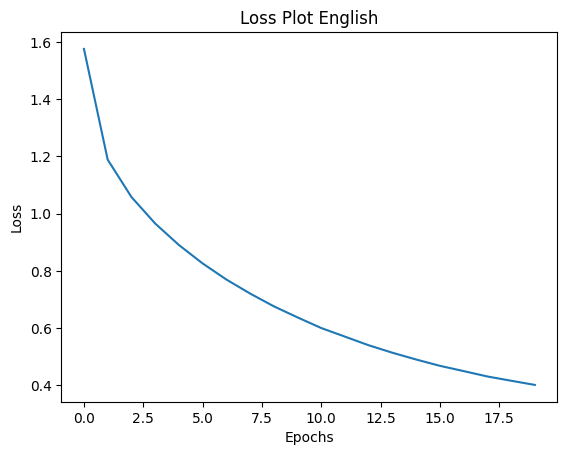

In [ ]:
plt.plot(loss_plot_english)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot English')
plt.show()

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer_english.index_word[i] for i in cap_val_english[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

Hindi Train 

In [ ]:
loss_plot_hindi = []
start_epoch = 0
EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target_hindi)) in enumerate(dataset_hindi):
        batch_loss, t_loss = train_step(img_tensor, target_hindi,decoder_hindi,tokenizer_hindi)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target_hindi.shape[1])))

    # storing the epoch end loss value to plot later
    loss_plot_english.append(total_loss / num_steps)

    print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss / num_steps))

    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer_hindi.index_word[i] for i in cap_val_hindi[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

Malayalam Training

In [ ]:
loss_plot_malayalam = []
start_epoch = 0
EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target_malayalam)) in enumerate(dataset_malayalam):
        batch_loss, t_loss = train_step(img_tensor, target_malayalam,decoder_malayalam,tokenizer_malayalam)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target_hindi.shape[1])))

    # storing the epoch end loss value to plot later
    loss_plot_english.append(total_loss / num_steps)

    print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss / num_steps))

    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer_malayalam.index_word[i] for i in cap_val_malayalam[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])